##Import packages & load data

In [1]:
import pandas as pd
import numpy as np
from numpy import where

!pip install autoimpute
from autoimpute.imputations import SingleImputer

import xgboost as xgb
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot, PredictionError
from sklearn.linear_model import LinearRegression, ARDRegression, BayesianRidge, Lasso, SGDRegressor
import matplotlib.pyplot as plt
#from matplotlib.pyplot import pyplot

from autoimpute.imputations import SingleImputer


# Hyperparameter Tuning Packages
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, TimeSeriesSplit

from xgboost import plot_importance
!pip install shap
import shap

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [167]:
# Read the excel dataset
df = pd.read_excel('/content/drive/MyDrive/MMAI/Finance/Alfred_Dataset.xlsx')

In [168]:
# check sample
print(df.shape)
df.head(3)

(180, 37)


,Date,Target_GreaterToronto_Single_Family_HPI,1Yr_MetroOntario_CPI_All,1M_MetroOntario_CPI_all,1Yr_MetroOntario_CPI_Shelter,1M_MetroOntario_CPI_Shelter,Month,1Yr_Lag,1M_Lag,1Yr_GreaterVancounver_Single_Family_HPI,1M_GreaterVancounver_Single_Family_HPI,1Yr_Calgary_Single_Family_HPI,1M_Calgary_Single_Family_HPI,1Yr_Montreal_Single_Family_HPI,1M_Montreal_Single_Family_HPI,1M_RealEstate_GDP_Trading_AdjustedConstant_BasePrice,1Yr_RealEstate_GDP_Trading_AdjustedConstant_BasePrice,1Yr_RetailSales_Toronto,1M_RetailSales_Toronto,1M_Avg_Temperature,1Yr_Avg_Temp,1M_Snow_onGround,1Yr_Snow_onGround,1Yr_Toronto_Median_Annual_Income_Couple_Families,1Yr_Toronto_Median_Annual_Income_Lone_Parent_Families,1M_Toronto_ConstructionCompletionsUnits,1Yr_Toronto_ConstructionCompletionsUnits,1M_Toronto_ConstructionStartsUnits,1Yr_Toronto_ConstructionStartsUnits,1M_Toronto_UnempRate_15_54_yrs,1Yr_BankRate_Canada,1M_BankRate_Canada,1M_Population,1Y_S&P500_Close,1M_S&P500_Close,1Y_Bachelors_Degree_Ontario_NewRegEducation,1Y_Bachelors_Degree_Ontario_NewRegAll
0,2006-01-01,106.4,105.1,107.6,107.4,110.2,1,100.0,105.7,100.0,110.4,100.0,114.7,100.0,103.8,14281,119542,4437136,4486253,-3.446452,-6.829677,1.348387,1.070968,69900.0,31600.0,3296,3173,3401,1681,NaN,2.75,3.50,5035000.000,1181.27,1248.29,11928,333234
1,2006-02-01,107.4,105.8,108.2,107.9,111.7,2,101.3,106.4,100.5,112.6,101.1,118.9,100.9,104.7,14336,125963,4479503,4528948,0.200000,-3.995000,0.251613,1.192857,69900.0,31600.0,4427,2761,2660,2296,NaN,2.75,3.75,5042500.000,1203.60,1280.08,11928,333234
2,2006-03-01,108.7,106.4,107.9,108.2,112.0,3,102.4,107.4,101.1,114.8,102.6,125.7,101.9,106.4,14601,124172,4376561,4556689,-3.567500,-1.621290,0.771429,0.825806,69900.0,31600.0,2882,5443,1539,2941,NaN,2.75,3.75,5050011.172,1180.59,1280.66,11928,333234


In [169]:
# New column for date year
df['Year'] = df['Date'].dt.year
# drop a silly feature
df = df.drop(columns=['1Y_Bachelors_Degree_Ontario_NewRegEducation',
                      '1Yr_Calgary_Single_Family_HPI',
                      '1M_Calgary_Single_Family_HPI'
                      ])

In [170]:
#remove bubble 
df = df[~df['Date'].isin(['2017-03-01','2017-08-01','2017-04-01','2017-05-01','2017-06-01','2017-07-01'])]

#fix construction
def val_fix(x):
  if x >= 5000:
    y = 5000
  else:
    y = x
  return y
df['1M_Toronto_ConstructionCompletionsUnits'] = df['1M_Toronto_ConstructionCompletionsUnits'].apply(val_fix)
df['1Yr_Toronto_ConstructionCompletionsUnits'] = df['1Yr_Toronto_ConstructionCompletionsUnits'].apply(val_fix)
df['1M_Toronto_ConstructionStartsUnits'] = df['1M_Toronto_ConstructionStartsUnits'].apply(val_fix)
df['1Yr_Toronto_ConstructionStartsUnits'] = df['1Yr_Toronto_ConstructionStartsUnits'].apply(val_fix)
#visualize
df.columns

Index(['Date', 'Target_GreaterToronto_Single_Family_HPI',
       '1Yr_MetroOntario_CPI_All', '1M_MetroOntario_CPI_all',
       '1Yr_MetroOntario_CPI_Shelter', '1M_MetroOntario_CPI_Shelter', 'Month',
       '1Yr_Lag', '1M_Lag', '1Yr_GreaterVancounver_Single_Family_HPI',
       '1M_GreaterVancounver_Single_Family_HPI',
       '1Yr_Montreal_Single_Family_HPI', '1M_Montreal_Single_Family_HPI',
       '1M_RealEstate_GDP_Trading_AdjustedConstant_BasePrice',
       '1Yr_RealEstate_GDP_Trading_AdjustedConstant_BasePrice',
       '1Yr_RetailSales_Toronto', '1M_RetailSales_Toronto',
       '1M_Avg_Temperature', '1Yr_Avg_Temp', '1M_Snow_onGround',
       '1Yr_Snow_onGround', '1Yr_Toronto_Median_Annual_Income_Couple_Families',
       '1Yr_Toronto_Median_Annual_Income_Lone_Parent_Families',
       '1M_Toronto_ConstructionCompletionsUnits',
       '1Yr_Toronto_ConstructionCompletionsUnits',
       '1M_Toronto_ConstructionStartsUnits',
       '1Yr_Toronto_ConstructionStartsUnits', '1M_Toronto_UnempRa

#**Modeling**

#Functions

In [133]:
def clean_data(df):
   
    clean_X = df.drop(['Target_GreaterToronto_Single_Family_HPI'], axis=1)
    clean_Y = df['Target_GreaterToronto_Single_Family_HPI']
    
    return clean_X, clean_Y

def split_data(clean_X, clean_Y, train_size):
    row_num = int(clean_X.shape[0]*train_size)
    
    X_train = clean_X[:row_num].drop(['Date'], axis=1)
    Y_train = clean_Y[:row_num]
    
    X_test  = clean_X[row_num:].drop(['Date'], axis=1)
    Y_test  = clean_Y[row_num:]

    X_test_date  = clean_X[row_num:][['Date']]

    imputer = SingleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    return X_train, X_test, Y_train, Y_test, X_test_date

def adj_r2(X, y, y_pred):
        r2 = r2_score(y,y_pred)
        adj_r2 = (1 - (1 - r2) * ((X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1)))
        return r2, adj_r2

def predict_test_values(model, X_test, y_test, X_test_date, X_train, y_train):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    y_test_pred_rmse = mean_squared_error(y_test,y_test_pred,squared=False)
    print (f'RMSE of Test Data: {y_test_pred_rmse}')
    
    r2_train, adj_r2_train = adj_r2(X_train, y_train,y_train_pred)
    r2_test, adj_r2_test = adj_r2(X_test, y_test, y_test_pred)
    
    print (f'Adjusted R2 of Train Data: {adj_r2_train}')
    print (f'R2 of Test Data: {r2_test}')
    
    #Populate dataframe for plotting
    df_test_actual = pd.DataFrame(y_test).rename({'TARGET':'y_test_actual'},axis=1).reset_index(drop=True)
    df_test_pred = pd.DataFrame(y_test_pred,columns=['y_test_pred']).reset_index(drop=True)
    df_test = pd.concat([X_test_date.reset_index(drop=True),df_test_actual,df_test_pred],axis=1)
    
    #Group results
    df_test_results = df_test.groupby(['Date']).sum()
    
    return df_test_results

def plot_test_results (df_test_results, model_num):
    
    model_names = {
    1: 'XGBoost',
    2: 'Bayesian',
    3: 'ARD Regression',
    4: 'Linear Regression',   
    5: 'Lasso',
    6: 'SGD'
    }
    title = model_names[model_num] + ' Actual vs. Model Results'
    
    plt.plot(df_test_results.index, df_test_results)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.legend(['Actual GreaterToronto_Single_Family_HPI','Predicted GreaterToronto_Single_Family_HPI']) 
    plt.grid(False)
    return plt.show()

def residual_plot(model,X, Y, hist=False,qqplot=True):
    """
    Plot *residual* to understand Homoscedasticity and heteroskedasticity
    Plot *q-q* plot for normality testing
    """
    visualizer = ResidualsPlot(model,hist=hist, qqplot=qqplot)
    visualizer.fit(X, Y) 
    return visualizer.show()

def feat_selection_step_1(model_num, X_train, y_train, X_test, y_test, top):
    """
    First stage of feature selection. Sort all faetures by predicitve power,
    by testing performance of features individually on predicting the target
    """
    rmse_score = []
    for i in range(0,len(X_train.columns)):
        X_train_samp = X_train.iloc[:, [i]]
        X_test_samp = X_test.iloc[:, [i]]
        model = models[model_num].fit(X_train_samp,y_train)
        y_test_pred = model.predict(X_test_samp)
        y_test_pred_rmse = mean_squared_error(y_test,y_test_pred,squared=False)
        rmse_score.append(y_test_pred_rmse)
        
    feature_rank = pd.DataFrame(list(zip(X_train.columns,rmse_score)), columns=['col_name','rmse_score'])
    feature_rank = feature_rank.sort_values('rmse_score')
    
    feature_rank = feature_rank.head(top)
    
    pd.set_option('display.max_rows', top)
    display(feature_rank)
    pd.set_option('display.max_rows', 20)
    
    
    X_train = X_train[list(feature_rank.col_name)]
    X_test  = X_test[list(feature_rank.col_name)]
    
    return feature_rank, X_train, X_test

def feat_selection_step_2(train_data, test_data, threshold):
    """
    Second stage of feature selection, using the top 50 features from stage 1, find the 
    single highest correlated feature to each of the 50 features using pearsons r.
    
    Remove cols higher then threshold.
    """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = train_data.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in train_data.columns:
                    #if colname not in ['WEEK_START_DATE_MONTH','WEEK_END_DATE_MONTH','WEEK_START_DATE_WEEK','WEEK_END_DATE_WEEK']:
                    if colname not in ['Year']:
                        print('Dropped:', colname)
                        del train_data[colname] # deleting the column from the dataset
                        del test_data[colname]
        
    
    return train_data, test_data


def tuner(params, folds, model, X_train, y_train):
    """
        Do a k fold hyperparamter tune using random search
    """
    
    kf = TimeSeriesSplit(n_splits=folds)
    
    random_search = RandomizedSearchCV(model, param_distributions=params, 
                                    n_iter=len(params), scoring='neg_root_mean_squared_error', n_jobs=4,
                                       cv=kf.split(X_train,y_train), verbose=3, random_state=1001)
    random_search.fit(X_train, y_train)
    
    print('\nBest hyperparameters: ', random_search.best_params_, "\nBest Score: ", random_search.best_score_)

    return random_search.best_params_, random_search.best_estimator_

In [171]:
models = {
    1: xgb.XGBRegressor(n_estimators=100, random_state=1),
    2: BayesianRidge(normalize=True, n_iter=1000),
    3: ARDRegression(),
    4: LinearRegression(),   
    5: Lasso(),
    6: SGDRegressor()

}

##Remove bubble and clean construction outliers

#Select a Model to Run

In [172]:
train_size = 0.85 #adjustable

clean_X, clean_Y = clean_data(df)
X_train, X_test, y_train, y_test, X_test_date = split_data(clean_X, clean_Y, train_size = train_size)

In [174]:
model_num = 2

##Model Building

In [175]:
# Base model shows overfitting, negative r2 on test
from sklearn.metrics import r2_score
model = models[model_num].fit(X_train,y_train)
y_pred_t = model.predict (X_train)
y_pred_test = model.predict (X_test)
print("r2 score on train: ",r2_score(y_train,y_pred_t))
print("r2 score on test: ",r2_score(y_test,y_pred_test))
print(f'RMSE on test: {mean_squared_error(y_test,y_pred_test,squared=False)}')

r2 score on train:  0.9996044537138516
r2 score on test:  0.7375439197135645
RMSE on test: 8.432303624674757


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ResidualsPlot(alpha=0.75,
              ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcabdec950>,
              hist=True, line_color=None, model=None, test_color=None,
              train_color=None)

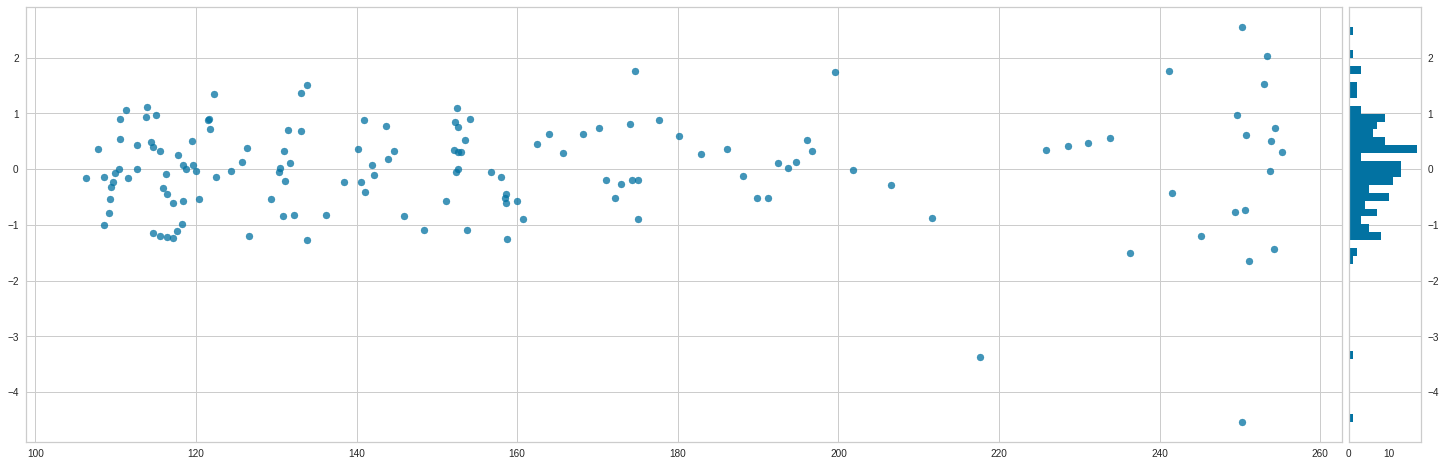

In [176]:
visualizer = ResidualsPlot(model,hist=True, qqplot=True)
visualizer.fit(X_train, y_train) 

#Feature Selection

In [177]:
# Feature selction stage 1
feature_rank, X_train_sel,X_test_sel = feat_selection_step_1(model_num, X_train,y_train, X_test, y_test, top=50)

,col_name,rmse_score
6,1M_Lag,2.237522
3,1M_MetroOntario_CPI_Shelter,9.074774
2,1Yr_MetroOntario_CPI_Shelter,10.616883
5,1Yr_Lag,12.809789
30,1M_S&P500_Close,14.426105
13,1Yr_RetailSales_Toronto,14.832033
29,1Y_S&P500_Close,16.216360
0,1Yr_MetroOntario_CPI_All,16.769936
9,1Yr_Montreal_Single_Family_HPI,18.916600
1,1M_MetroOntario_CPI_all,21.276379


In [178]:
print(X_train_sel.shape)
print(X_test_sel.shape)

(147, 33)
(27, 33)


In [210]:
# Feature selction stage 2
X_train_final, X_test_final = feat_selection_step_2(X_train_sel,X_test_sel, threshold = 0.4)

In [211]:
#and drop highly negative
X_train_final = X_train_final.drop(columns=['Year','1M_Snow_onGround','1Yr_Snow_onGround'])
X_test_final = X_test_final.drop(columns=['Year','1M_Snow_onGround','1Yr_Snow_onGround'])

In [212]:
print(X_train_final.shape)
print(X_test_final.shape)

(147, 9)
(27, 9)


#Hyperparameter tuning

In [213]:
params = [{
#     XGRegessor
    'learning_rate': [i/10.0 for i in range(0,10)],
    'n_estimators': range(0,400,50),
    'max_depth':range(1,8,1),
    'gamma':[i/10.0 for i in range(0,5)],
        },
    { 
#     BaysianRidge
    'alpha_1': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'alpha_2': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'fit_intercept': [True, False],    
    },
    { 
#     ARD regressor
    'alpha_1': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'alpha_2': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'lambda_1': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'lambda_2': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'fit_intercept': [True, False],    
    }]

In [214]:
folds = 3

tuned_params, tuned_model = tuner(params=params[model_num - 1], folds=folds, model=model, X_train=X_train_final, y_train=y_train)

# Retrain tuned model and test RMSE
tuned_model = tuned_model.fit(X_train_final,y_train)
df_test_results = predict_test_values(tuned_model, X_test_final, y_test, X_test_date, X_train_final, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best hyperparameters:  {'fit_intercept': True, 'alpha_2': 0.001, 'alpha_1': 10} 
Best Score:  -1.78917216659503
RMSE of Test Data: 2.0836500169677716
Adjusted R2 of Train Data: 0.9990127195210822
R2 of Test Data: 0.9839744215537555


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    0.1s finished


#Re-train Optimized Model

In [215]:
model = tuned_model.fit(X_train_final,y_train)

RMSE of Test Data: 2.0836500169677716
Adjusted R2 of Train Data: 0.9990127195210822
R2 of Test Data: 0.9839744215537555


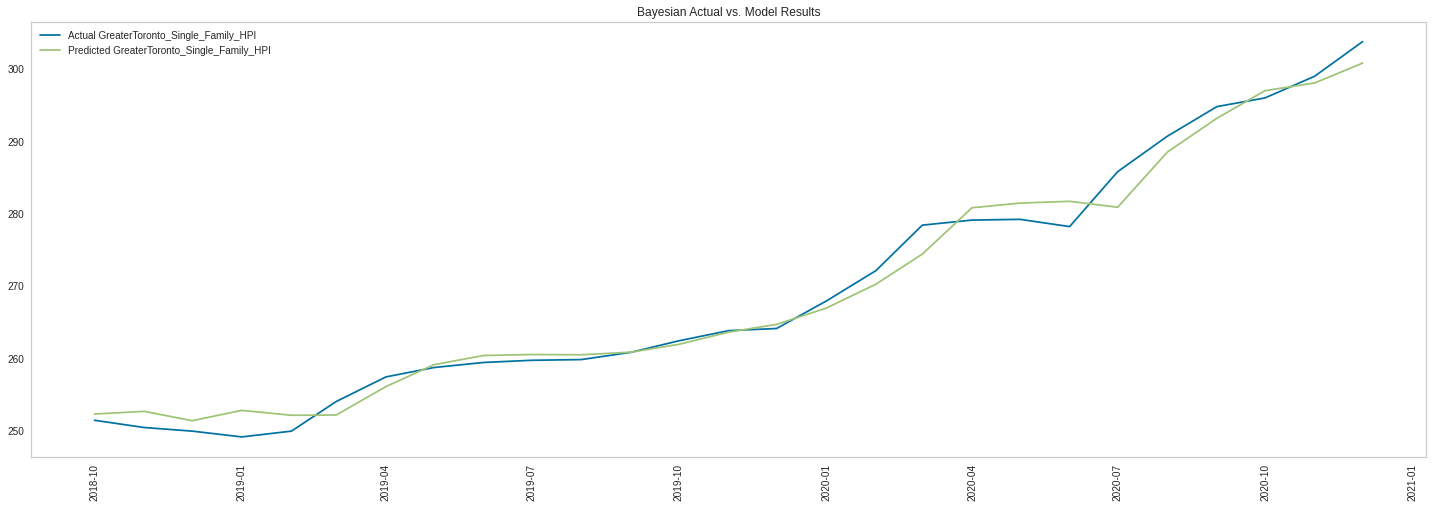

In [216]:
df_test_results = predict_test_values(model, X_test_final, y_test, X_test_date, X_train_final, y_train)
plt.rcParams["figure.figsize"] = (25,8)
plot_test_results(df_test_results, model_num)

In [217]:
print ('Columns to use for Feature Selection Slides')
X_train_final.columns

Columns to use for Feature Selection Slides


Index(['1M_Lag', '1M_BankRate_Canada', 'Month', '1Yr_Avg_Temp',
       '1Yr_Toronto_ConstructionCompletionsUnits',
       '1Yr_Toronto_ConstructionStartsUnits',
       '1M_Toronto_ConstructionStartsUnits',
       '1M_Toronto_ConstructionCompletionsUnits',
       '1M_Toronto_UnempRate_15_54_yrs'],
      dtype='object')

In [218]:
pd.DataFrame(list(zip(X_train_final.columns,model.coef_))).to_csv('bayesian_feature_selection_coef2.csv')

In [219]:
model.intercept_

-1.1150670291767142

In [220]:
list(zip(X_train_final.columns,model.coef_))

[('1M_Lag', 1.0089968867763681),
 ('1M_BankRate_Canada', -0.13326927104233294),
 ('Month', -0.16497303946734176),
 ('1Yr_Avg_Temp', -0.027729432036495173),
 ('1Yr_Toronto_ConstructionCompletionsUnits', 6.713795785164246e-05),
 ('1Yr_Toronto_ConstructionStartsUnits', 0.00019156352055211021),
 ('1M_Toronto_ConstructionStartsUnits', 7.310491987106811e-05),
 ('1M_Toronto_ConstructionCompletionsUnits', 2.553881864435627e-05),
 ('1M_Toronto_UnempRate_15_54_yrs', 0.17711381461086684)]

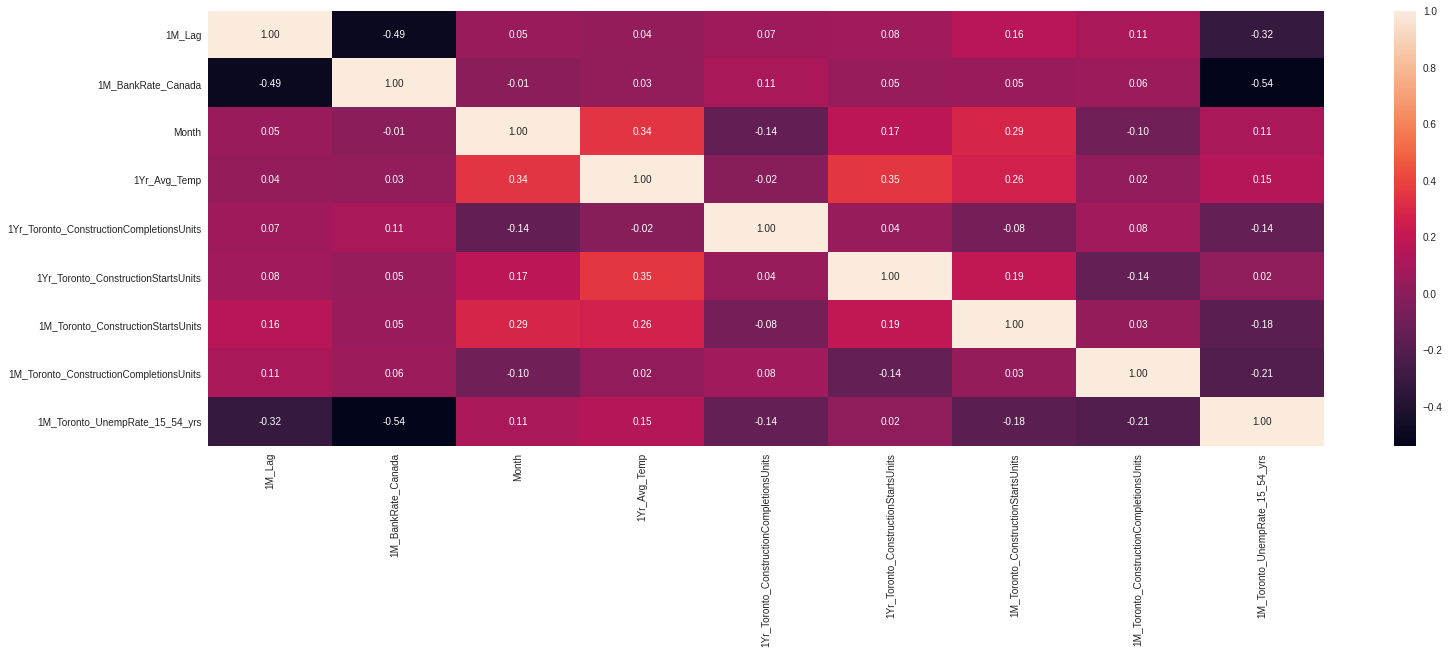

In [221]:
# distribution with standardized data
import seaborn as sns
sns.heatmap(X_train_final.corr(), annot=True, fmt=".2f")
plt.show()

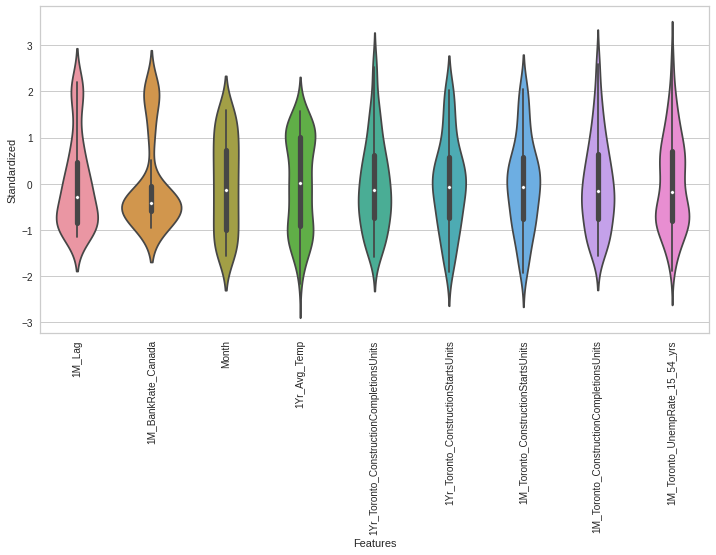

In [224]:
# distribution with standardized data
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train_std = pd.DataFrame(scale.fit_transform(X_train_final),columns=X_train_final.columns)

df_std = X_train_std.melt(var_name='Features', value_name='Standardized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Features', y='Standardized', data=df_std)
_ = ax.set_xticklabels(X_train_std.columns, rotation=90)